<a href="https://colab.research.google.com/github/YosefAshraf24/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [1]:
!gdown 1Gw6BTJPHtqpamE8tT-8YpL8WX-knUVT0
!unzip Crema.zip -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/1031_DFA_DIS_XX.wav  
  inflating: Data/1031_DFA_FEA_XX.wav  
  inflating: Data/1031_DFA_HAP_XX.wav  
  inflating: Data/1031_DFA_NEU_XX.wav  
  inflating: Data/1031_DFA_SAD_XX.wav  
  inflating: Data/1031_IEO_ANG_HI.wav  
  inflating: Data/1031_IEO_ANG_LO.wav  
  inflating: Data/1031_IEO_ANG_MD.wav  
  inflating: Data/1031_IEO_DIS_HI.wav  
  inflating: Data/1031_IEO_DIS_LO.wav  
  inflating: Data/1031_IEO_DIS_MD.wav  
  inflating: Data/1031_IEO_FEA_HI.wav  
  inflating: Data/1031_IEO_FEA_LO.wav  
  inflating: Data/1031_IEO_FEA_MD.wav  
  inflating: Data/1031_IEO_HAP_HI.wav  
  inflating: Data/1031_IEO_HAP_LO.wav  
  inflating: Data/1031_IEO_HAP_MD.wav  
  inflating: Data/1031_IEO_NEU_XX.wav  
  inflating: Data/1031_IEO_SAD_HI.wav  
  inflating: Data/1031_IEO_SAD_LO.wav  
  inflating: Data/1031_IEO_SAD_MD.wav  
  inflating: Data/1031_IOM_ANG_XX.wav  
  inflating: Data/1031_IOM_DIS_XX.wav  
  inflating: Data/1031_IOM_FE

In [2]:
import os
import copy
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from IPython.display import Audio

# Load the Dataset

In [3]:
# Define a mapping from labels to integers
labels2int = {
    "SAD": 0,
    "ANG": 1,
    "DIS": 2,
    "FEA": 3,
    "HAP": 4,
    "NEU": 5
}

# Define a mapping from integers to labels
int2labels = list(labels2int.keys())

def load_dataset(dir_path):
    """Load CREMA dataset from dir_path.
    Audio with duration less than 3 seconds will be padded with zeros.
    Otherwise, it will be truncated to 3 seconds.

    Args:
        dir_path (str): Path to the dataset directory.

    Returns:
        data (torch.Tensor): Tensor of shape (n_samples, 3 * 16000).
        labels (torch.Tensor): Tensor of shape (n_samples,).
    """
    # Get all the filenames
    files = os.listdir(dir_path)

    # Initialize the tensors
    labels = torch.empty(len(files), dtype=torch.int64)
    data = torch.empty((len(files), 3 * 16000), dtype=torch.float32)

    # Define the sample rate and maximum size of waveform
    sample_rate = 16000
    max_size = sample_rate * 3

    # Iterate over all files and load their waveforms and labels
    for i, file in enumerate(files):
        waveform = torchaudio.load(os.path.join(dir_path, file))[0][0]
        if waveform.shape[0] < max_size:
            waveform = F.pad(waveform, (0, max_size - waveform.shape[0]))
        elif waveform.shape[0] > max_size:
            waveform = waveform[:max_size]
        labels[i] = labels2int[file[9:12]]
        data[i] = waveform

    return data, labels

In [6]:
# Load the dataset
data, labels = load_dataset("/content/Data")

# Create the Feature Space

In [7]:
def to_energy(data, frame_length=1024, hop_length=128):
    """Compute energy of each frame in a batch of waveforms.

    Args:
        data (torch.Tensor): Tensor of audio of dimension (channel, time)
        frame_length (int): Length of each frame (window)
        hop_length (int): Number of samples to hop
    
    Returns:
        energy (torch.Tensor): Tensor of dimension (channel, time)
    """
    # Compute the energy of each frame
    energy = torch.empty(data.shape[0], data.shape[1] // hop_length + 1)
    for i in range(energy.shape[1]):
        energy[:, i] = torch.sum(data[:, i * hop_length : i * hop_length + frame_length] ** 2, dim=1)

    return energy

In [8]:
def to_zero_crossing_rate(data, frame_length=1024, hop_length=128):
    """Compute zero crossing rate of each frame in a batch of waveforms.

    Args:
        data (torch.Tensor): Tensor of audio of dimension (channel, time)
        frame_length (int): Length of each frame (window)
        hop_length (int): Number of samples to hop
    
    Returns:
        zcr (torch.Tensor): Tensor of dimension (channel, time)
    """
    # Compute the zero crossing rate of each frame
    zcr = torch.empty(data.shape[0], data.shape[1] // hop_length + 1)
    for i in range(zcr.shape[1]):
        zcr[:, i] = torch.sum(torch.abs(torch.diff((data[:, i * hop_length : i * hop_length + frame_length] > 0) * 1, dim=1)), dim=1)

    return zcr

In [9]:
def to_spec(data):
    """Convert wavforms to spectrograms

    Args:
        data (torch.Tensor): Tensor of waveforms

    Returns:
        torch.Tensor: Tensor of spectrograms
    """
    # Compute the spectrogram of each waveform
    spec = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=512, n_mels=128)(data)
    spec = torchaudio.transforms.AmplitudeToDB()(spec)
    return spec

In [10]:
# Convert waveforms to energy
energy = to_energy(data, 4096)

In [11]:
# Convert waveforms to zero crossing rate
zcr = to_zero_crossing_rate(data, 256)

In [12]:
# Convert waveforms to spectrograms
spec = to_spec(data)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


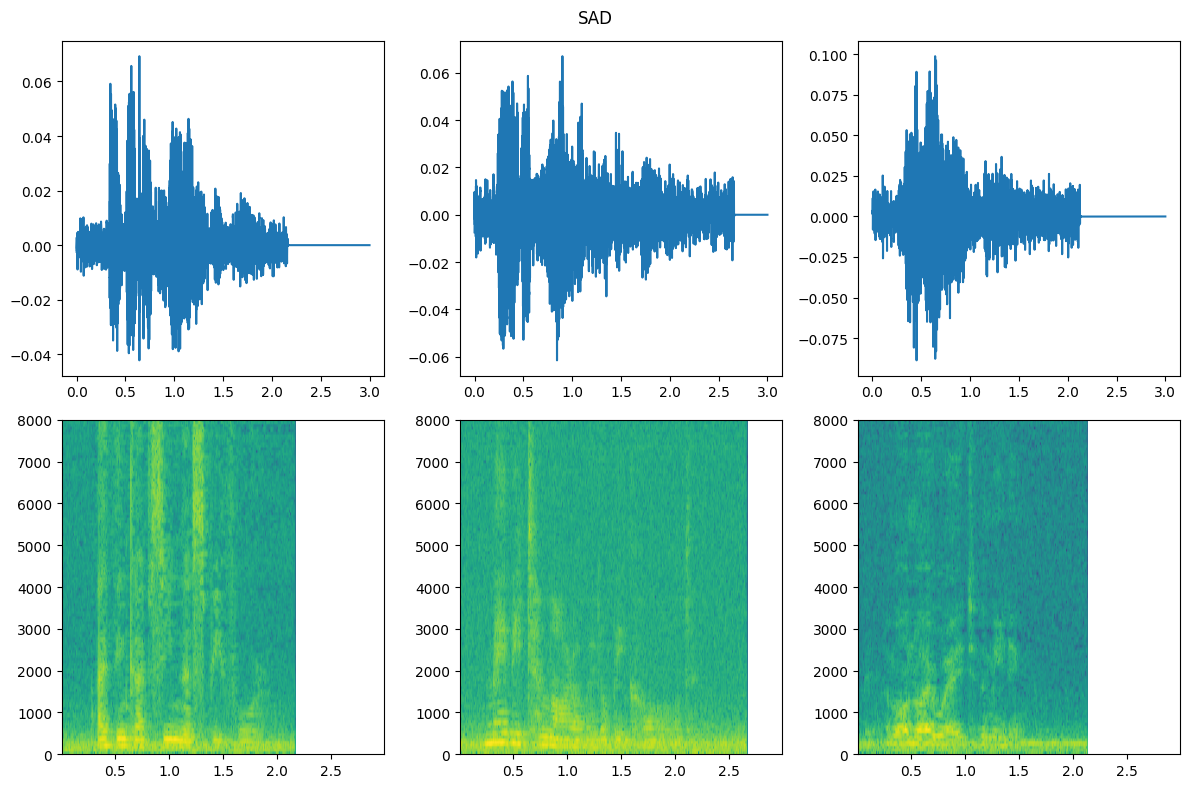

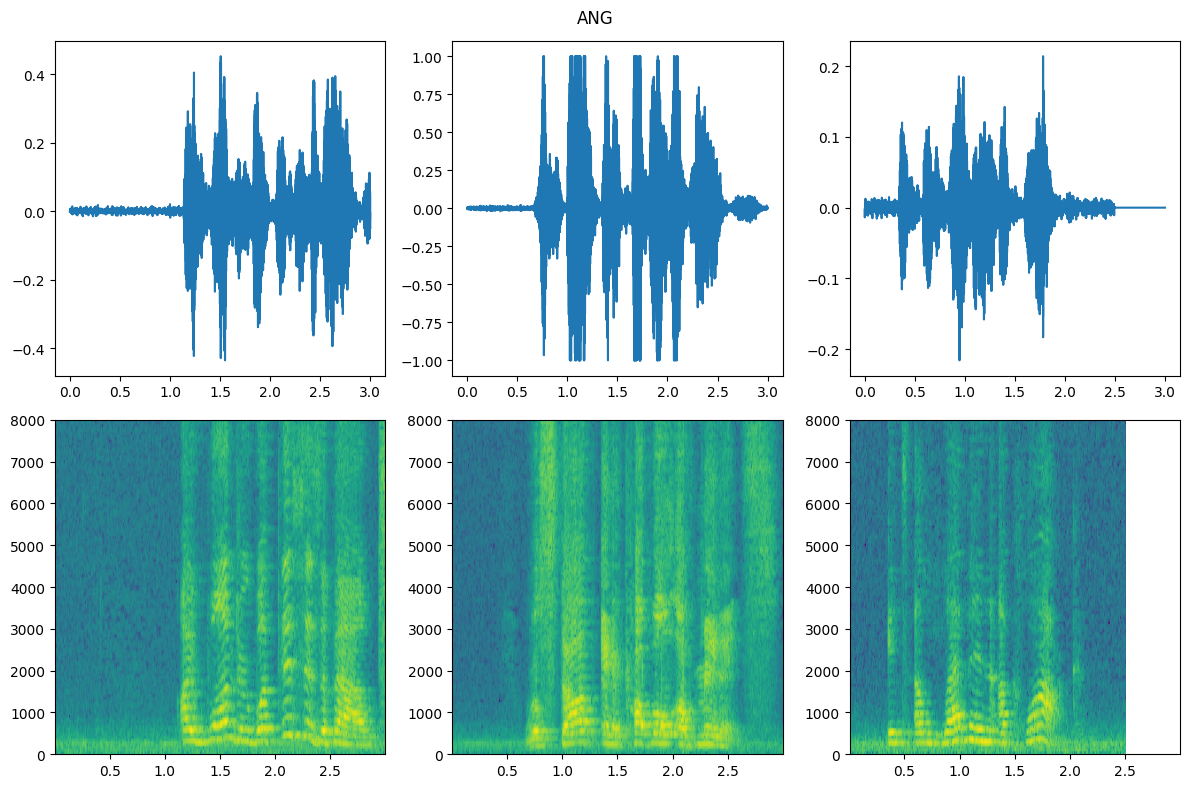

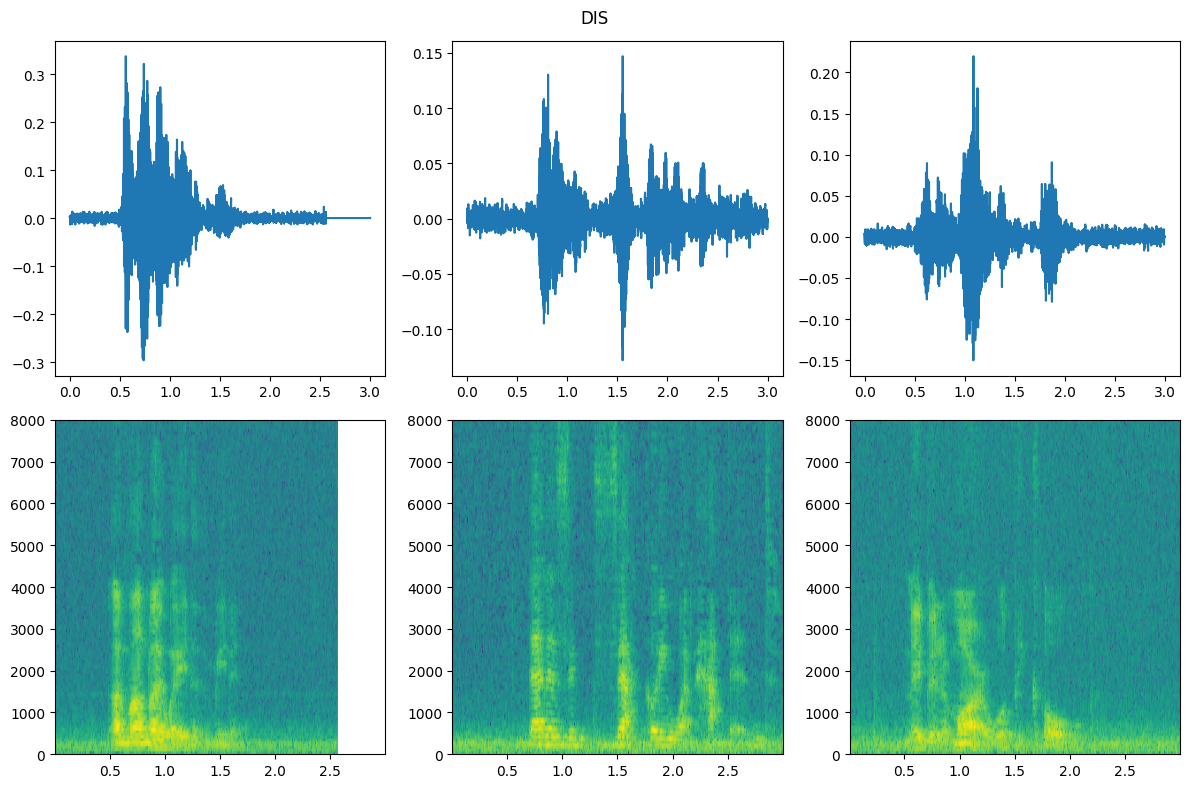

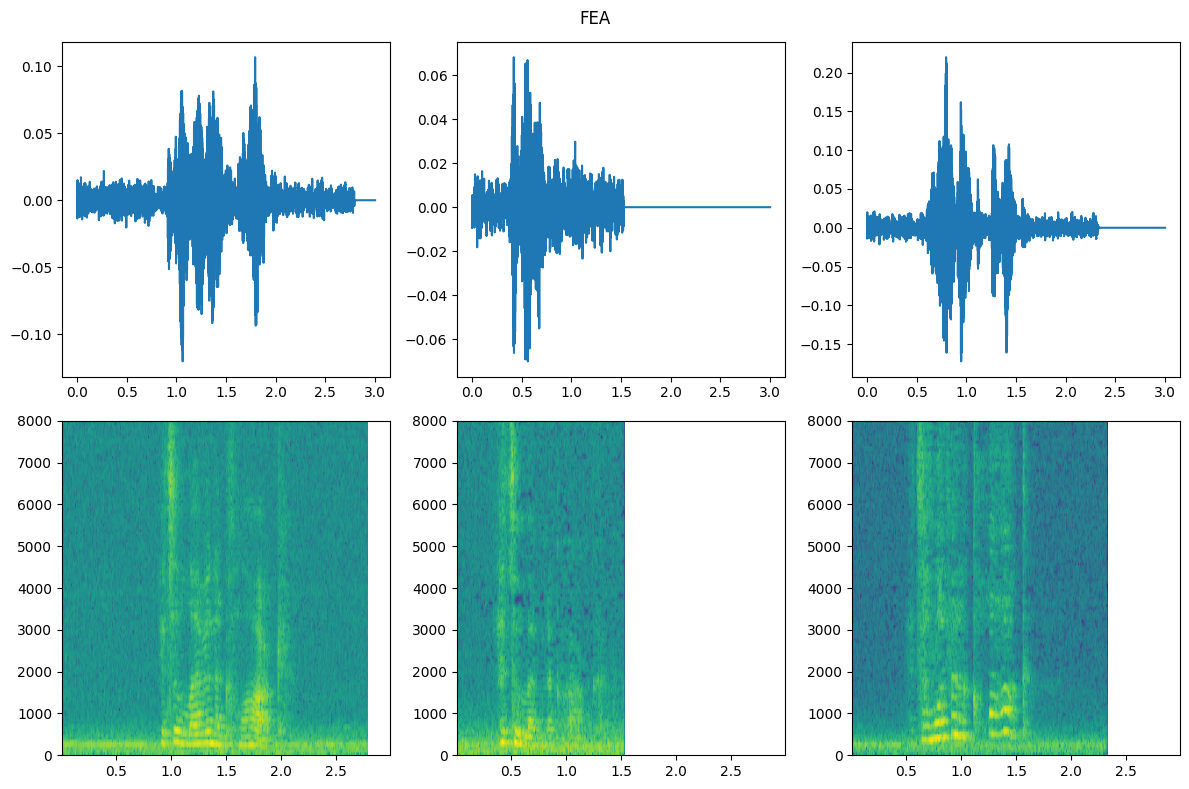

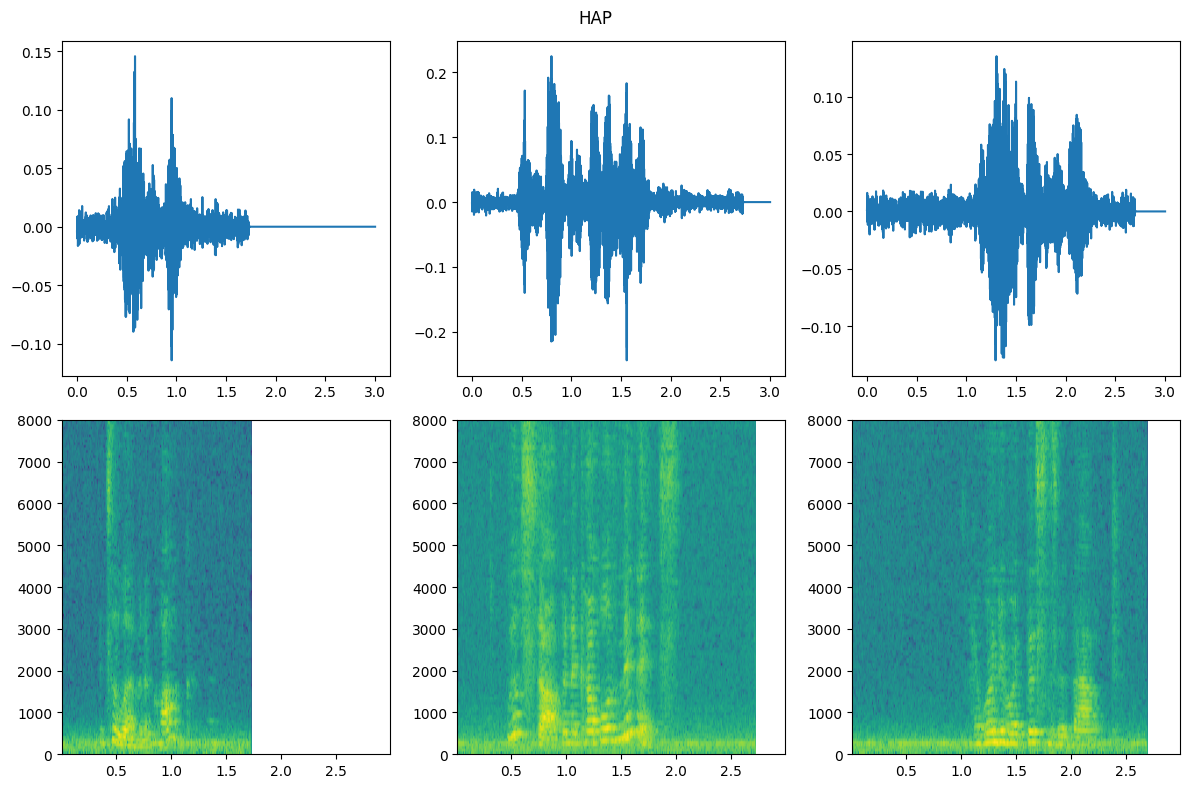

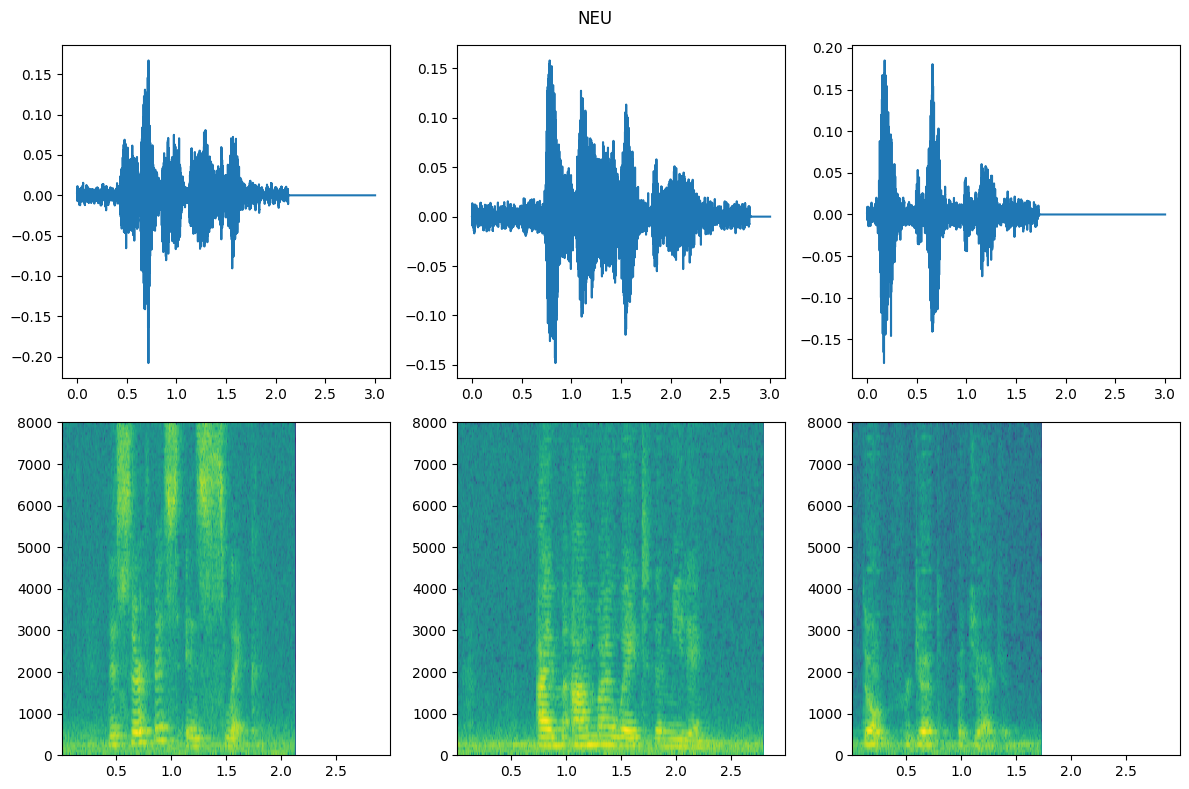

In [13]:
# Show information about random 3 samples from each class
for i in range(len(int2labels)):
    # Get all waveforms of class i
    waveforms_i = torch.where(labels == i)[0]
    # Choose 4 random waveforms
    waveforms_i = waveforms_i[torch.randperm(len(waveforms_i))[:3]]
    # Initialize figure
    fig, axes = plt.subplots(2, 3)
    # Maintain the aspect ratio
    fig.set_size_inches(12, 8)
    # Set title
    fig.suptitle(int2labels[i])
    for j, waveform_idx in enumerate(waveforms_i):
        # Compute x-axis for the waveform
        time_axis = torch.arange(0, data[waveform_idx].shape[0]) / 16000
        # Plot the waveform
        axes[0, j].plot(time_axis, data[waveform_idx].numpy())
        # Plot the spectrogram
        axes[1, j].specgram(data[waveform_idx].numpy(), Fs=16000)
    plt.tight_layout()
    plt.show(block=False)
    # Display audio widgets to play the waveforms
    for waveform_idx in waveforms_i:
        display(Audio(data[waveform_idx].numpy(), rate=16000))

# Split the Dataset

In [14]:
# Split energy and zcr into train and test sets
energy_train, energy_test, zcr_train, zcr_test, spec_train, spec_test, labels_train, labels_test = \
    train_test_split(energy, zcr, spec, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

# Split train into train and validation sets
energy_train, energy_val, zcr_train, zcr_val, spec_train, spec_val, labels_train, labels_val = \
    train_test_split(energy_train, zcr_train, spec_train, labels_train, test_size=0.05, random_state=42, shuffle=True, stratify=labels_train)

# Initialize Dataloaders

In [17]:
# Train the model with GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# Initialize the training dataloader
train_dataset = TensorDataset(energy_train.unsqueeze(1), zcr_train.unsqueeze(1), spec_train.unsqueeze(1), labels_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the validation dataloader
val_dataset = TensorDataset(energy_val.unsqueeze(1), zcr_val.unsqueeze(1), spec_val.unsqueeze(1), labels_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Initialize the test dataloader
test_dataset = TensorDataset(energy_test.unsqueeze(1), zcr_test.unsqueeze(1), spec_test.unsqueeze(1), labels_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# CNN model for Time Domain features

In [15]:
# Define the CNN model for time domain features
class TimeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 64, 32, stride=1, padding='same')
        self.pool1 = nn.AvgPool1d(2, stride=2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 16, stride=1, padding='same')
        self.pool2 = nn.AvgPool1d(2, stride=2)
        self.conv3 = nn.Conv1d(64, 32, 8, stride=2, padding='valid')
        self.pool3 = nn.AvgPool1d(2, stride=2)
        self.conv4 = nn.Conv1d(32, 32, 4, stride=1, padding='same')
        self.pool4 = nn.AvgPool1d(2, stride=2)
        self.fc1 = nn.Linear(32 * 11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, len(int2labels))

    def forward(self, energies, zcrs):
        x = torch.stack([energies, zcrs], dim=1)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.view(x.shape[0], -1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [18]:
def train_time_model(model, criterion, epochs, train_loader, val_loader, device):
    """Train the model based on time domain features.

    Args:
        model (nn.Module): The model to be trained.
        criterion: The loss function.
        epochs (int): The number of epochs to train the model.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        device (torch.device): The device to run the model on.
    """
    # Declare the best model weights
    best_model_wts = copy.deepcopy(model.state_dict())

    # Declare the minimum validation loss
    min_val_loss = np.inf

    # Initialize the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Iterate over epochs
    for epoch in range(epochs):
        # Declare the training and validation loss and accuracy
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Train the model on training data
        model.train()
        # Iterate over training data batches
        for energies, zcrs, specs, labels in train_loader:
            # Transfer the data to the device
            energies = energies.to(device)
            zcrs = zcrs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            model.zero_grad()

            # Forward pass
            outputs = model(energies, zcrs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Apply backpropagation
            loss.backward()
            optimizer.step()

            # Update the training loss and accuracy
            train_loss += loss.item() * energies.size(0)
            train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Validate the model on validation data
        model.eval()
        # Iterate over validation data batches
        for energies, zcrs, specs, labels in val_loader:
            # Transfer the data to the device
            energies = energies.to(device)
            zcrs = zcrs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(energies, zcrs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update the validation loss and accuracy
            val_loss += loss.item() * energies.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Update the optimizer type and learning rate based on the epoch
        if epoch == 40:
            optimizer = optim.Adam(model.parameters(), lr=0.000001)
            
        # Calculate the average losses and accuracies
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_acc / len(val_loader.dataset)

        # Print the losses and accuracies for the current epoch
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}\n\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}\n'.format(
            epoch, train_loss, train_acc, val_loss, val_acc))
        
        # Save the model weights if the validation loss is less than the minimum validation loss
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    # Load the best model weights
    model.load_state_dict(best_model_wts)

In [19]:
# Declare the time domain model
time_model = TimeNetwork().to(device)
# Declare the loss function
criterion = nn.CrossEntropyLoss()

In [20]:
# Train the time domain model
train_time_model(time_model, criterion, 40, train_loader, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 0 	Training Loss: 1.743357 	Training Accuracy: 0.209984
		Validation Loss: 1.709917 	Validation Accuracy: 0.245211

Epoch: 1 	Training Loss: 1.552292 	Training Accuracy: 0.334074
		Validation Loss: 1.516769 	Validation Accuracy: 0.390805

Epoch: 2 	Training Loss: 1.488545 	Training Accuracy: 0.376112
		Validation Loss: 1.471980 	Validation Accuracy: 0.425287

Epoch: 3 	Training Loss: 1.468000 	Training Accuracy: 0.389248
		Validation Loss: 1.484346 	Validation Accuracy: 0.406130

Epoch: 4 	Training Loss: 1.452656 	Training Accuracy: 0.396322
		Validation Loss: 1.464154 	Validation Accuracy: 0.417625

Epoch: 5 	Training Loss: 1.441595 	Training Accuracy: 0.407842
		Validation Loss: 1.476096 	Validation Accuracy: 0.425287

Epoch: 6 	Training Loss: 1.432194 	Training Accuracy: 0.407033
		Validation Loss: 1.450063 	Validation Accuracy: 0.452107

Epoch: 7 	Training Loss: 1.444645 	Training Accuracy: 0.409256
		Validation Loss: 1.430816 	Validation Accuracy: 0.452107

Epoch: 8 	Traini

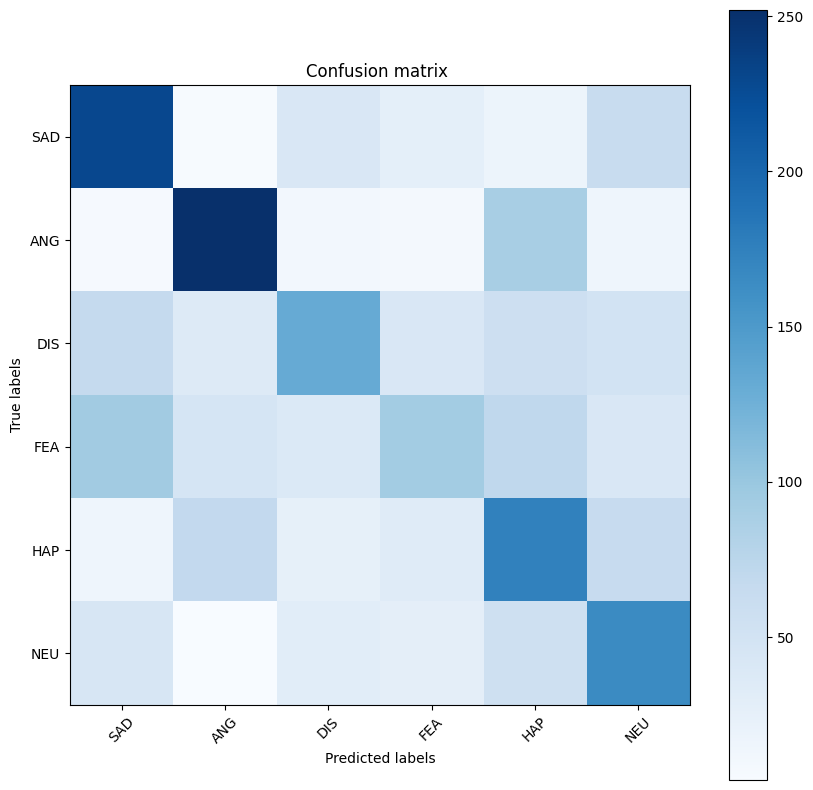

Accuracy: 0.4675324675324675
F1 Score: 0.4591607602417863


In [21]:
# Declare the lists to store the predictions and true labels
y_pred = []
y_true = []

# Freeze the model weights
with torch.no_grad():
    # Iterate over test data batches
    for energies, zcrs, specs, labels_batch in test_loader:
        # Transfer the data to the device
        energies = energies.to(device)
        zcrs = zcrs.to(device)
        labels_batch = labels_batch.to(device)

        # Forward pass
        outputs = time_model(energies, zcrs)

        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Store the predicted and true labels
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels_batch.cpu().numpy())

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(int2labels)), int2labels, rotation=45)
plt.yticks(np.arange(len(int2labels)), int2labels)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# Calculate the accuracy of the trained model
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

# Calculate the f1 score of the trained model
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")

# CNN model for Frequency Domain features

In [22]:
# Define the CNN model for time domain features
class SpecNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 32, stride=1, padding='same')
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(64, 64, 16, stride=1, padding='same')
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(64, 32, 8, stride=2, padding='valid')
        self.pool3 = nn.AvgPool2d(2, stride=2)
        self.conv4 = nn.Conv2d(32, 32, 4, stride=1, padding='same')
        self.pool4 = nn.AvgPool2d(2, stride=2)
        self.fc1 = nn.Linear(32 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, len(int2labels))

    def forward(self, specs):
        x = F.relu(self.conv1(specs))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [23]:
def train_spec_model(model, criterion, epochs, train_loader, val_loader, device):
    """Train the model based on frequency domain features.

    Args:
        model (nn.Module): The model to be trained.
        criterion: The loss function.
        epochs (int): The number of epochs to train the model.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        device (torch.device): The device to run the model on.
    """
    # Initialize the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Iterate over epochs
    for epoch in range(epochs):
        # Declare the training and validation loss and accuracy
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Train the model on training data
        model.train()
        # Iterate over training data batches
        for energies, zcrs, specs, labels in train_loader:
            # Transfer the data to the device
            specs = specs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            model.zero_grad()

            # Forward pass
            outputs = model(specs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Apply backpropagation
            loss.backward()
            optimizer.step()

            # Update the training loss and accuracy
            train_loss += loss.item() * energies.size(0)
            train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Validate the model on validation data
        model.eval()
        # Iterate over validation data batches
        for energies, zcrs, specs, labels in val_loader:
            # Transfer the data to the device
            specs = specs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(specs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update the validation loss and accuracy
            val_loss += loss.item() * energies.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Change the optimizer after 10 epochs
        if epoch == 10:
            optimizer = optim.Adam(model.parameters(), lr=0.000001)
            
        # Calculate the average losses and accuracies
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_acc / len(val_loader.dataset)

        # Print the losses and accuracies for the current epoch
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}\n\t\tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}\n'.format(
            epoch, train_loss, train_acc, val_loss, val_acc))

In [24]:
# Declare the frequency domain model
spec_model = SpecNetwork().to(device)
# Declare the loss function
criterion = nn.CrossEntropyLoss()

In [25]:
# Train the frequency domain model
train_spec_model(spec_model, criterion, 20, train_loader, val_loader, device)

Epoch: 0 	Training Loss: 1.788131 	Training Accuracy: 0.195432
		Validation Loss: 1.813942 	Validation Accuracy: 0.180077

Epoch: 1 	Training Loss: 1.760177 	Training Accuracy: 0.214834
		Validation Loss: 1.732340 	Validation Accuracy: 0.241379

Epoch: 2 	Training Loss: 1.632615 	Training Accuracy: 0.312449
		Validation Loss: 1.626138 	Validation Accuracy: 0.352490

Epoch: 3 	Training Loss: 1.527011 	Training Accuracy: 0.367421
		Validation Loss: 1.508998 	Validation Accuracy: 0.375479

Epoch: 4 	Training Loss: 1.486442 	Training Accuracy: 0.388238
		Validation Loss: 1.500056 	Validation Accuracy: 0.386973

Epoch: 5 	Training Loss: 1.473062 	Training Accuracy: 0.390663
		Validation Loss: 1.471289 	Validation Accuracy: 0.429119

Epoch: 6 	Training Loss: 1.471260 	Training Accuracy: 0.392684
		Validation Loss: 1.515010 	Validation Accuracy: 0.402299

Epoch: 7 	Training Loss: 1.441287 	Training Accuracy: 0.406427
		Validation Loss: 1.473827 	Validation Accuracy: 0.432950

Epoch: 8 	Traini

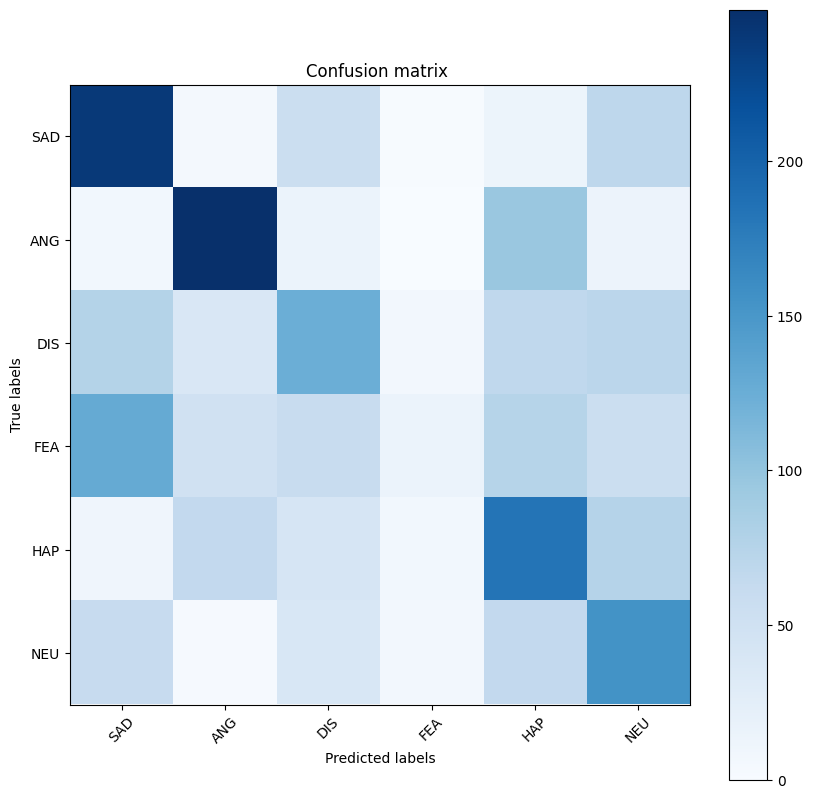

Accuracy: 0.432154052843708
F1 Score: 0.40017717426899885


In [26]:
# Declare the lists to store the predictions and true labels
y_pred = []
y_true = []

# Freeze the model weights
with torch.no_grad():
    # Iterate over test data batches
    for energies, zcrs, specs, labels_batch in test_loader:
        # Transfer the data to the device
        specs = specs.to(device)
        labels_batch = labels_batch.to(device)

        # Forward pass
        outputs = spec_model(specs)

        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Store the predicted and true labels
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels_batch.cpu().numpy())

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(int2labels)), int2labels, rotation=45)
plt.yticks(np.arange(len(int2labels)), int2labels)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# Calculate the accuracy of the trained model
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

# Calculate the f1 score of the trained model
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")